## Requirements

In [40]:
import nltk
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Data loader and split

In [52]:
dataset = pd.read_csv('data/cleaned_dataset_processed.csv', nrows=1000)
print(dataset.head(5))
print(dataset.shape)


                                              review  rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                                      cleaned_review  
0  nice expensive parking got good deal anniversa...  
1  ok nothing special charge diamond member hilto...  
2  nice experience monarch seattle good level pos...  
3  unique great wonderful time monarch location e...  
4  great great went sea hawk game awesome downfal...  
(1000, 3)


In [53]:
def split_data_stratified(X, y, test_size=0.2, random_state=42):
    """
    Split data ensuring proportional representation of all classes
    """
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    
    # Get indices for train and test splits
    for train_idx, test_idx in sss.split(X, y):
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]
    
    print("Class distribution in splits:")
    print("\nTraining set:")
    print(y_train.value_counts().sort_index())
    print("\nTest set:")
    print(y_test.value_counts().sort_index())
    
    return X_train, X_test, y_train, y_test

In [54]:
X = dataset['cleaned_review']
y = dataset['rating']

X_train, X_test, y_train, y_test = split_data_stratified(X, y)

Class distribution in splits:

Training set:
rating
1     88
2     86
3    110
4    249
5    267
Name: count, dtype: int64

Test set:
rating
1    22
2    22
3    27
4    62
5    67
Name: count, dtype: int64


## Functions and pipelines

In [55]:
def create_param_grids():
    """Define parameter grids for each model"""
    param_grids = {
        'Logistic Regression': {
            'vectorizer__max_features': [1000, 2000, 3000],
            'vectorizer__ngram_range': [(1,1), (1,2)],
            'classifier__C': [0.1, 1.0, 10.0],
        },
        'SVM': {
            'vectorizer__max_features': [1000, 2000, 3000, 4000],
            'vectorizer__ngram_range': [(1,1), (1,2)],
            'classifier__estimator__C': [0.1, 1.0, 10.0],
        },
        'Random Forest': {
            'vectorizer__max_features': [1000, 2000],
            'vectorizer__ngram_range': [(1,1), (1,2)],
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20, None],
        },
        'XGBoost': {
            'vectorizer__max_features': [2000, 3000],
            'vectorizer__ngram_range': [(1,1), (1,2)],
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 5, 6],
            'classifier__learning_rate': [0.01, 0.1, 0.05],
        },
        'Naive Bayes': {
            'vectorizer__max_features': [1000, 2000, 3000],
            'vectorizer__ngram_range': [(1,1), (1,2)],
            'classifier__alpha': [0.1, 0.5, 1.0],
        }
    }
    return param_grids

In [58]:


def plot_learning_curves(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Plot learning curves for a given estimator"""
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

def plot_grid_search_results(grid_search, param_name):
    """Plot grid search results for a specific parameter"""
    # Clear any existing plots
    plt.clf()
    
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Get the parameter values
    param_values = [params[param_name] for params in results['params']]
    
    # Calculate mean scores for each parameter value
    mean_scores = {}
    std_scores = {}
    for value, mean, std in zip(param_values, 
                               results['mean_test_score'],
                               results['std_test_score']):
        if value not in mean_scores:
            mean_scores[value] = []
            std_scores[value] = []
        mean_scores[value].append(mean)
        std_scores[value].append(std)
    
    # Calculate average for each parameter value
    unique_values = sorted(set(param_values))
    mean_scores = [np.mean(mean_scores[value]) for value in unique_values]
    std_scores = [np.mean(std_scores[value]) for value in unique_values]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.errorbar(range(len(unique_values)), mean_scores, 
                yerr=std_scores, fmt='o-')
    
    # Set the x-axis labels
    plt.xticks(range(len(unique_values)), unique_values)
    
    # Labels and title
    plt.xlabel(param_name)
    plt.ylabel('Mean CV Score')
    plt.title(f'Grid Search Results for {param_name}')
    plt.grid(True)
    
    # Add value labels
    for i, score in enumerate(mean_scores):
        plt.text(i, score, f'{score:.3f}', 
                horizontalalignment='center',
                verticalalignment='bottom')
    
    plt.tight_layout()
    plt.show()

def plot_all_param_results(grid_search, param_grid):
    """Plot grid search results for all parameters"""
    n_params = len(param_grid)
    if n_params == 0:
        return
        
    # Calculate subplot layout
    n_cols = min(3, n_params)
    n_rows = (n_params + n_cols - 1) // n_cols
    
    plt.figure(figsize=(6*n_cols, 4*n_rows))
    
    for i, param_name in enumerate(param_grid.keys(), 1):
        plt.subplot(n_rows, n_cols, i)
        
        results = pd.DataFrame(grid_search.cv_results_)
        param_values = [params[param_name] for params in results['params']]
        
        # Custom sorting function that handles None
        def sort_key(x):
            if x is None:
                return float('inf')  # Place None at the end
            return x
        
        # Calculate mean scores for each parameter value
        mean_scores = {}
        std_scores = {}
        for value, mean, std in zip(param_values, 
                                   results['mean_test_score'],
                                   results['std_test_score']):
            if value not in mean_scores:
                mean_scores[value] = []
                std_scores[value] = []
            mean_scores[value].append(mean)
            std_scores[value].append(std)
        
        # Sort values handling None
        unique_values = sorted(set(param_values), key=sort_key)
        mean_scores = [np.mean(mean_scores[value]) for value in unique_values]
        std_scores = [np.mean(std_scores[value]) for value in unique_values]
        
        # Convert values to strings for display
        x_labels = ['None' if v is None else str(v) for v in unique_values]
        
        # Plot
        plt.errorbar(range(len(unique_values)), mean_scores, 
                    yerr=std_scores, fmt='o-')
        plt.xticks(range(len(unique_values)), x_labels, rotation=45)
        plt.xlabel(param_name)
        plt.ylabel('Mean CV Score')
        plt.title(f'Grid Search Results - {param_name}')
        plt.grid(True)
        
        # Add value labels
        for j, score in enumerate(mean_scores):
            plt.text(j, score, f'{score:.3f}', 
                    horizontalalignment='center',
                    verticalalignment='bottom')
    
    plt.tight_layout()
    plt.show()

def compare_models_with_grid_search(X_train, X_test, y_train, y_test):
    # Transform labels from 1-5 to 0-4
    y_train_transformed = y_train - 1
    y_test_transformed = y_test - 1

    # Get number of unique classes
    n_classes = len(np.unique(np.concatenate([y_train_transformed, y_test_transformed])))
    
    # Define pipelines
    pipelines = {
        'Logistic Regression': Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('classifier', LogisticRegression(max_iter=1000))
        ]),
        'SVM': Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('classifier', OneVsRestClassifier(LinearSVC(random_state=42)))
        ]),
        'Random Forest': Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('classifier', RandomForestClassifier(random_state=42))
        ]),
        'XGBoost': Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('classifier', XGBClassifier(
                random_state=42,
                objective='multi:softmax',
                num_class=n_classes,
                eval_metric='mlogloss',
                enable_categorical=True  # Add this instead of use_label_encoder
            ))
        ]),
        'Naive Bayes': Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('classifier', MultinomialNB())
        ])
    }

    param_grids = create_param_grids()
    results = {}

    for name, pipeline in pipelines.items():
        print(f"\nTraining {name} with Grid Search...")
        
        # Perform grid search
        grid_search = GridSearchCV(
            pipeline,
            param_grids[name],
            cv=5,
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X_train, y_train_transformed)
        
        # Store best model results
        y_pred = grid_search.predict(X_test)
        y_pred_original = y_pred + 1
        y_test_original = y_test_transformed + 1

        results[name] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'train_score': grid_search.score(X_train, y_train_transformed),
            'test_score': grid_search.score(X_test, y_test_transformed),
            'classification_report': classification_report(y_test_original, y_pred_original),
            'confusion_matrix': confusion_matrix(y_test_original, y_pred_original),
            'grid_search': grid_search
        }

        # Print results
        print(f"\n{name} Results:")
        print(f"Best parameters: {results[name]['best_params']}")
        print(f"Best CV score: {results[name]['best_score']:.3f}")
        print(f"Training accuracy: {results[name]['train_score']:.3f}")
        print(f"Testing accuracy: {results[name]['test_score']:.3f}")
        print("\nClassification Report:")
        print(results[name]['classification_report'])

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        cm = results[name]['confusion_matrix']
        cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues')
        plt.title(f'{name} - Confusion Matrix (%)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        # Plot learning curves for best model
        plot_learning_curves(
            grid_search.best_estimator_,
            f'Learning Curves - {name}',
            X_train, y_train_transformed
        )

        # Plot grid search results for all parameters
        print(f"\nGrid Search Results for {name}:")
        plot_all_param_results(grid_search, param_grids[name])

        # Add this after other plots
        print(f"\nTop Features for {name}:")
        plot_top_features(grid_search.best_estimator_, name)
        print(f"\nClass-specific Features for {name}:")
        plot_top_features_by_class(grid_search.best_estimator_, name)

    return results

def plot_model_comparison(results):
    """Plot comparison of model performances"""
    try:
        # Prepare data
        models = list(results.keys())
        train_scores = [results[m]['train_score'] for m in models]
        test_scores = [results[m]['test_score'] for m in models]

        # Create plot
        x = np.arange(len(models))
        width = 0.35

        fig, ax = plt.subplots(figsize=(12, 6))
        rects1 = ax.bar(x - width/2, train_scores, width, label='Train')
        rects2 = ax.bar(x + width/2, test_scores, width, label='Test')

        # Customize plot
        ax.set_ylabel('Accuracy')
        ax.set_title('Model Performance Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45)
        ax.legend()

        # Add value labels
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.3f}',
                          xy=(rect.get_x() + rect.get_width() / 2, height),
                          xytext=(0, 3),
                          textcoords="offset points",
                          ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in model comparison plot: {str(e)}")

def plot_top_features_by_class(model, model_name, n_features=10):
    """
    Plot top features for each class separately (for models that support it)
    """
    try:
        vectorizer = model.named_steps['vectorizer']
        feature_names = vectorizer.get_feature_names_out()
        
        if model_name in ['Logistic Regression', 'SVM']:
            coefficients = model.named_steps['classifier'].coef_
            n_classes = coefficients.shape[0]
            
            # Create subplot grid
            n_cols = 2
            n_rows = (n_classes + 1) // 2
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
            axes = axes.ravel()
            
            for i in range(n_classes):
                # Get top features for this class
                class_coef = coefficients[i]
                top_positive_idx = np.argsort(class_coef)[-n_features:]
                top_negative_idx = np.argsort(class_coef)[:n_features]
                
                # Plot
                ax = axes[i]
                y_pos = np.arange(n_features * 2)
                
                # Combine positive and negative features
                features = np.concatenate([
                    feature_names[top_negative_idx],
                    feature_names[top_positive_idx]
                ])
                importances = np.concatenate([
                    class_coef[top_negative_idx],
                    class_coef[top_positive_idx]
                ])
                
                ax.barh(y_pos, importances)
                ax.set_yticks(y_pos)
                ax.set_yticklabels(features)
                ax.set_title(f'Class {i+1} Important Features')
            
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"Could not plot class-specific features for {model_name}: {str(e)}")

def plot_top_features(model, model_name, n_features=20):
    """
    Plot top n_features for each model
    """
    try:
        # Get vectorizer and feature names
        vectorizer = model.named_steps['vectorizer']
        feature_names = vectorizer.get_feature_names_out()
        
        # Get feature importance based on model type
        if model_name in ['Random Forest', 'XGBoost']:
            # Tree-based models
            importances = model.named_steps['classifier'].feature_importances_
            importance_type = 'Feature Importance'
        
        elif model_name == 'Logistic Regression':
            # Get absolute values of coefficients (average across classes for multiclass)
            importances = np.abs(model.named_steps['classifier'].coef_).mean(axis=0)
            importance_type = 'Coefficient Magnitude'
        
        elif model_name == 'SVM':
            # For LinearSVC, get coefficients from the underlying estimator
            importances = np.abs(model.named_steps['classifier'].estimator.coef_).mean(axis=0)
            importance_type = 'Coefficient Magnitude'
        
        elif model_name == 'Naive Bayes':
            # For Naive Bayes, use feature log probabilities
            importances = np.exp(model.named_steps['classifier'].feature_log_prob_).mean(axis=0)
            importance_type = 'Feature Probability'
        
        # Get top n features
        top_indices = np.argsort(importances)[-n_features:]
        top_features = feature_names[top_indices]
        top_importances = importances[top_indices]
        
        # Plot
        plt.figure(figsize=(10, 8))
        plt.barh(range(n_features), top_importances[::-1])
        plt.yticks(range(n_features), top_features[::-1])
        plt.xlabel(importance_type)
        plt.title(f'Top {n_features} Most Important Features - {model_name}')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not plot feature importance for {model_name}: {str(e)}")

## Train and Analysis


Training Logistic Regression with Grid Search...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Logistic Regression Results:
Best parameters: {'classifier__C': 10.0, 'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 1)}
Best CV score: 0.521
Training accuracy: 0.999
Testing accuracy: 0.485

Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.41      0.50        22
           2       0.38      0.27      0.32        22
           3       0.26      0.26      0.26        27
           4       0.46      0.53      0.50        62
           5       0.58      0.63      0.60        67

    accuracy                           0.48       200
   macro avg       0.47      0.42      0.44       200
weighted avg       0.49      0.48      0.48       200



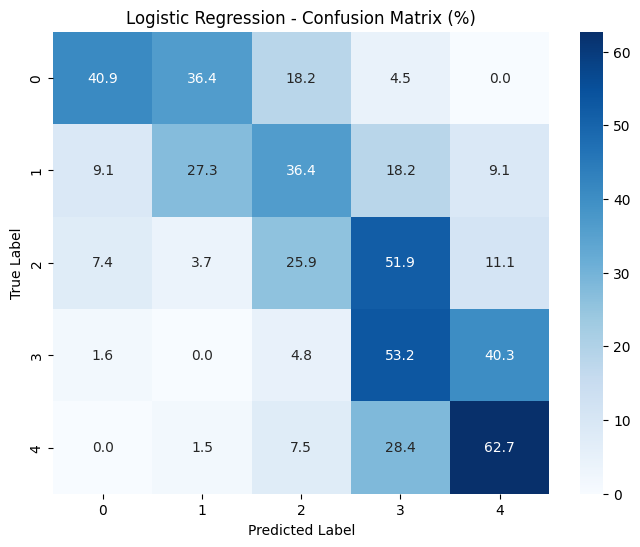

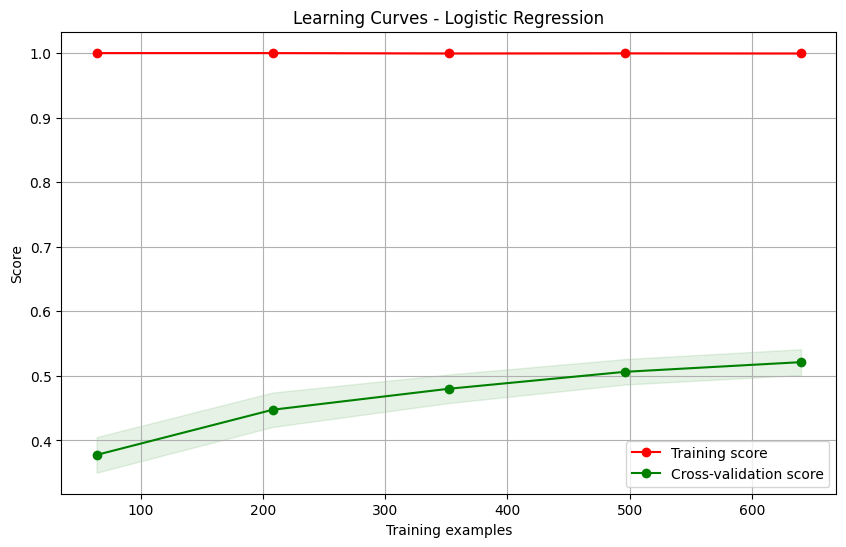


Grid Search Results for Logistic Regression:


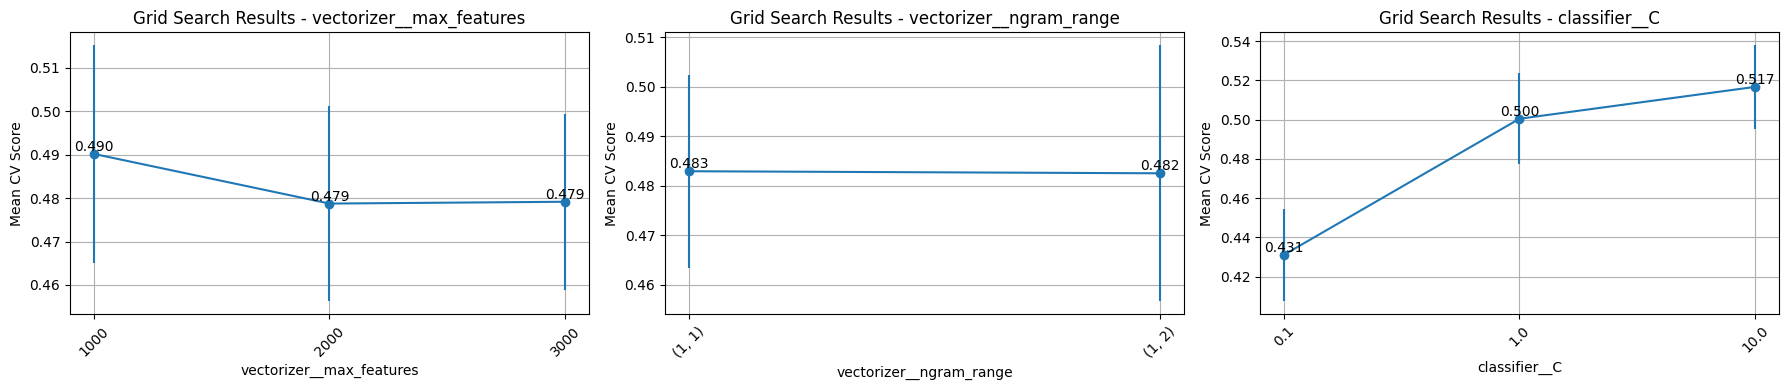


Top Features for Logistic Regression:


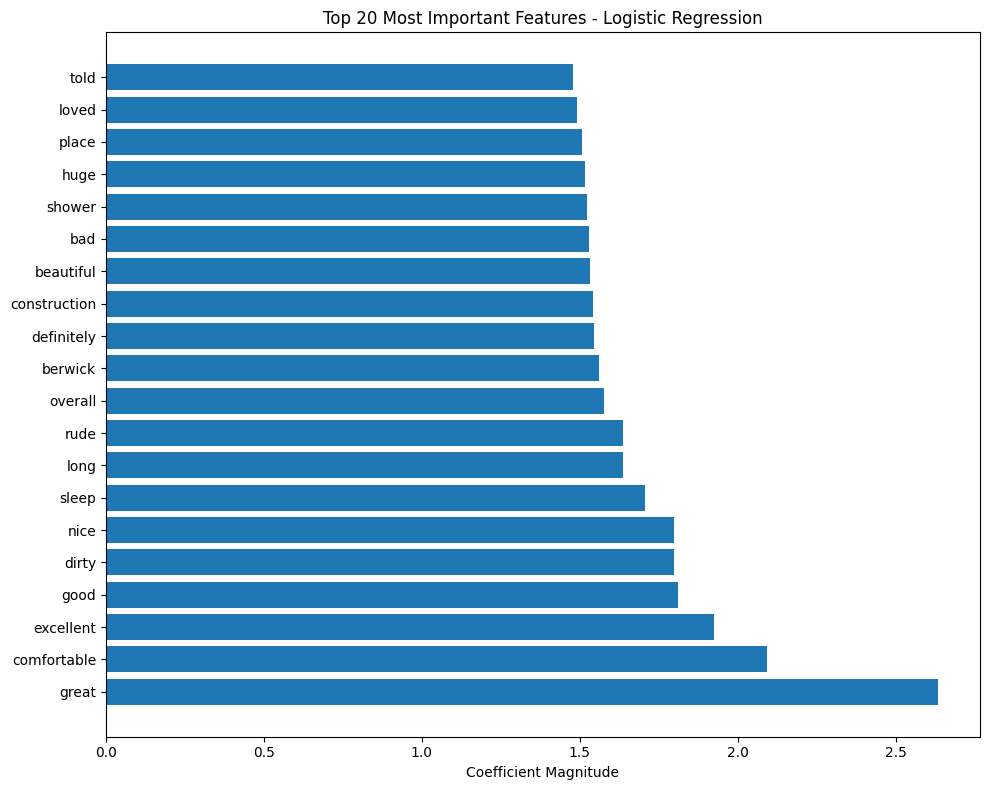


Class-specific Features for Logistic Regression:


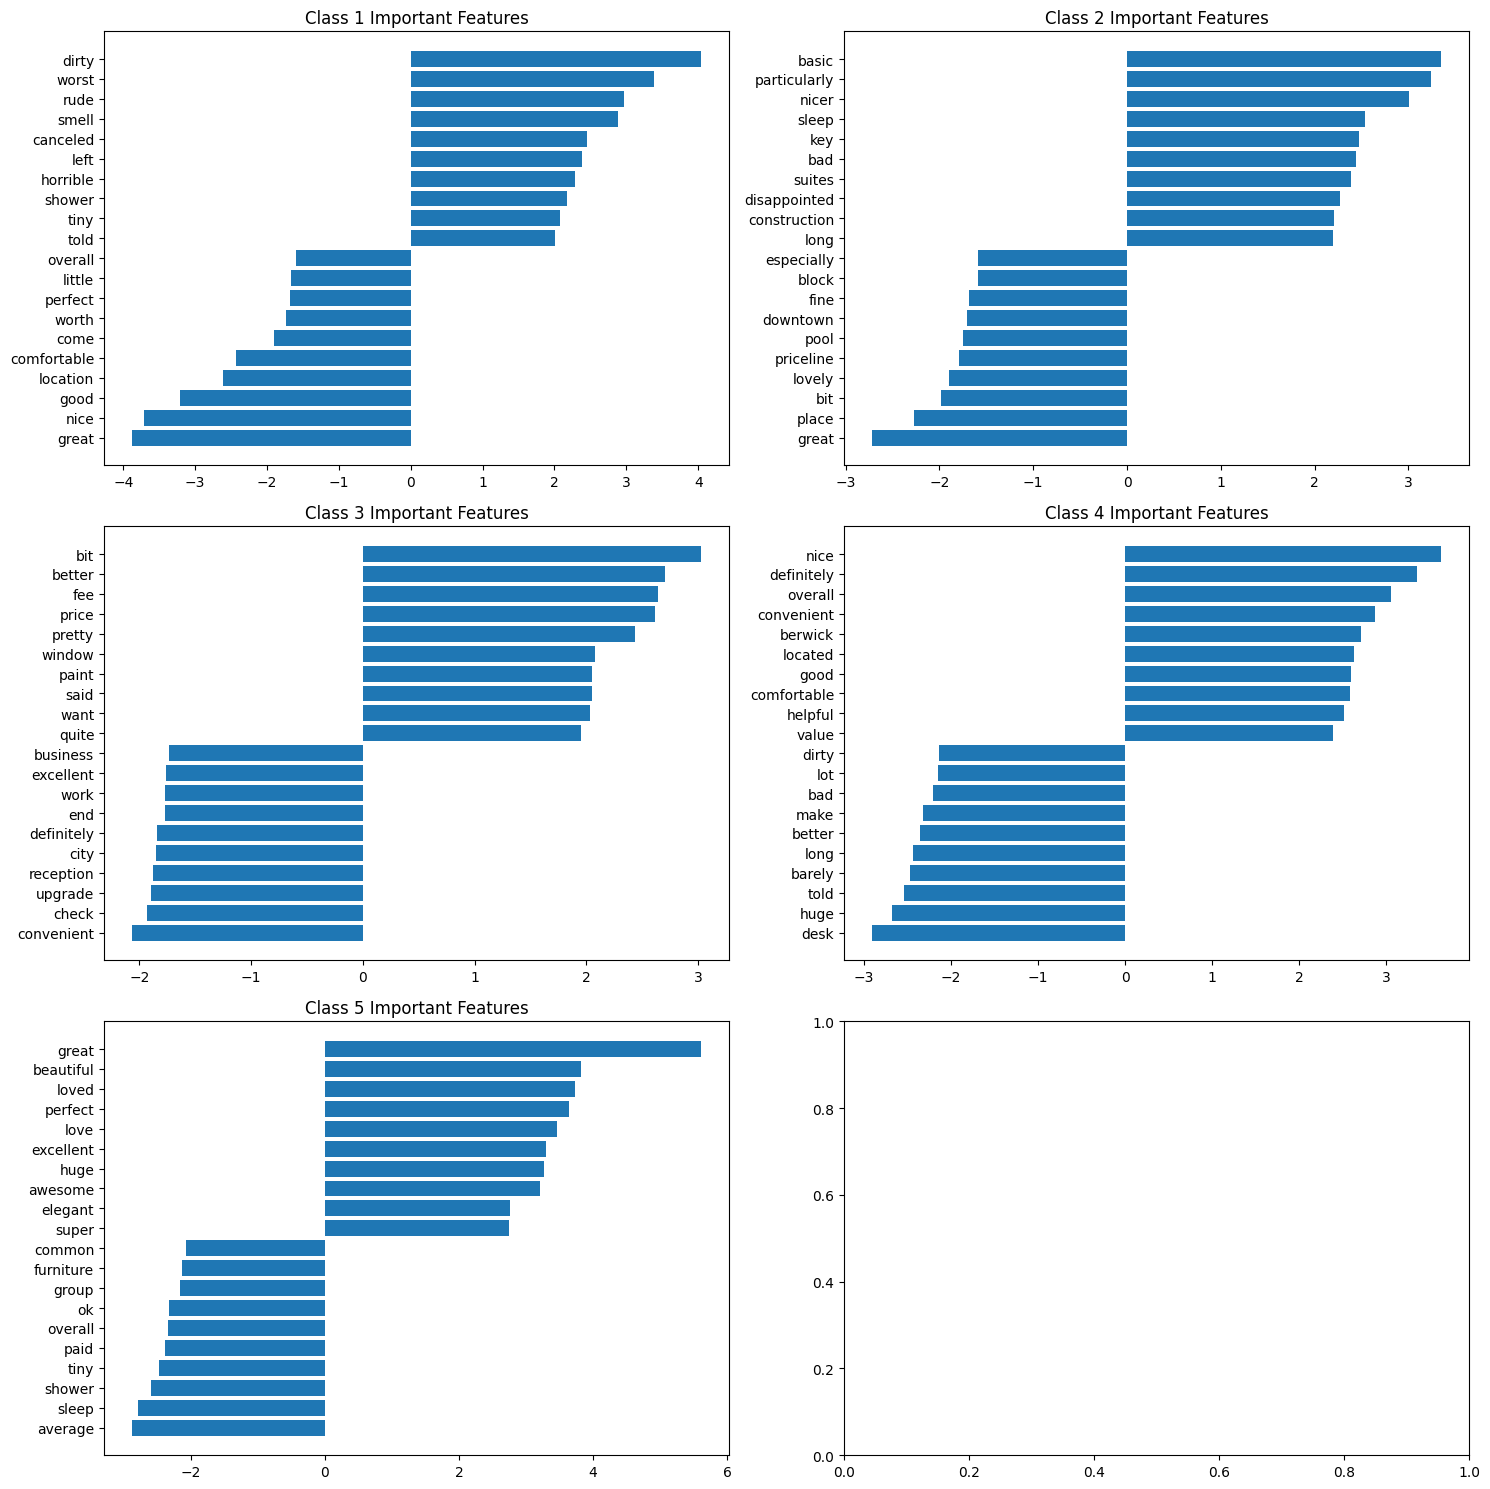


Training SVM with Grid Search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

SVM Results:
Best parameters: {'classifier__estimator__C': 1.0, 'vectorizer__max_features': 4000, 'vectorizer__ngram_range': (1, 2)}
Best CV score: 0.532
Training accuracy: 1.000
Testing accuracy: 0.485

Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.45      0.53        22
           2       0.30      0.14      0.19        22
           3       0.32      0.30      0.31        27
           4       0.43      0.47      0.45        62
           5       0.57      0.70      0.63        67

    accuracy                           0.48       200
   macro avg       0.45      0.41      0.42       200
weighted avg       0.47      0.48      0.47       200



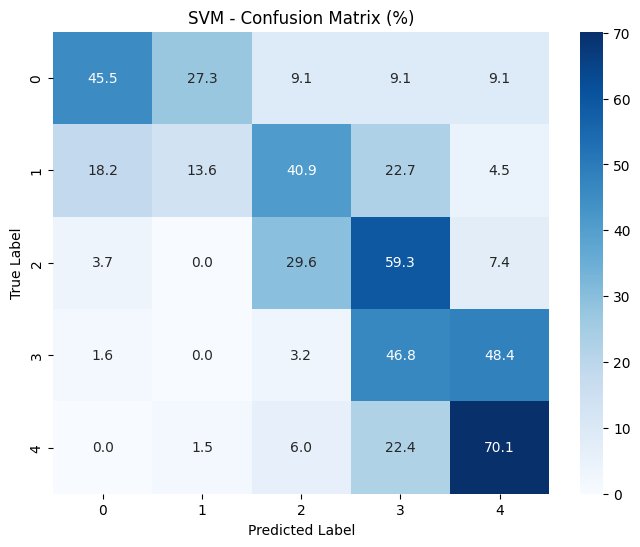

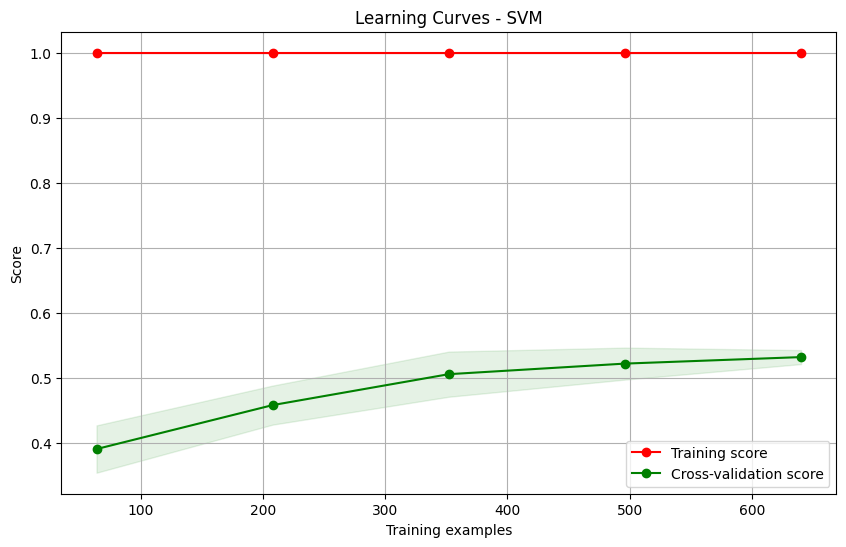


Grid Search Results for SVM:


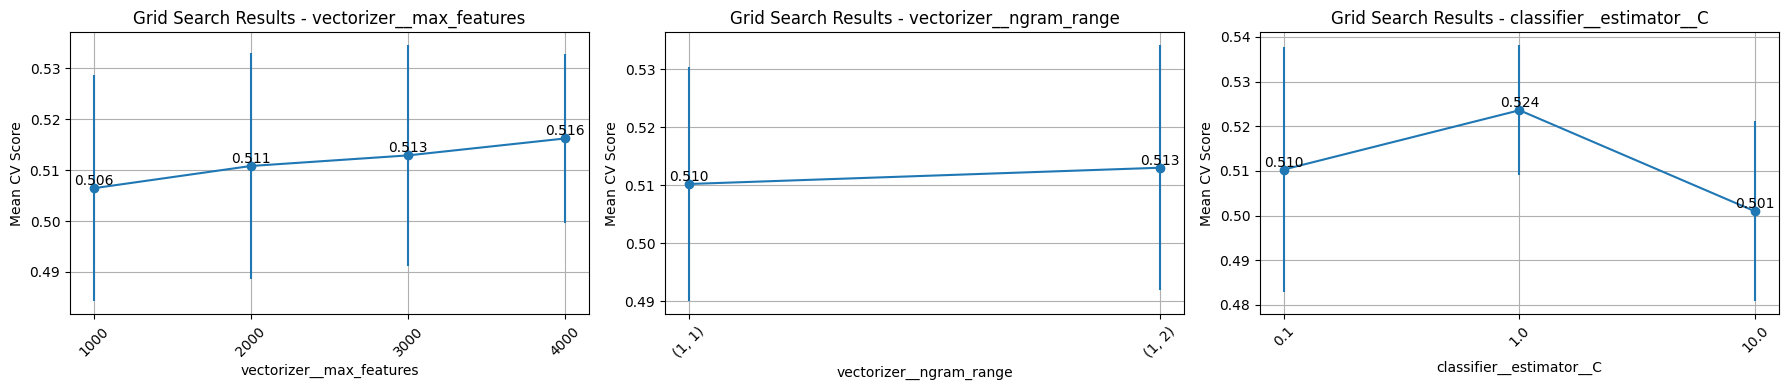


Top Features for SVM:
Could not plot feature importance for SVM: 'LinearSVC' object has no attribute 'coef_'

Class-specific Features for SVM:
Could not plot class-specific features for SVM: 'OneVsRestClassifier' object has no attribute 'coef_'

Training Random Forest with Grid Search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Random Forest Results:
Best parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 100, 'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 1)}
Best CV score: 0.512
Training accuracy: 1.000
Testing accuracy: 0.450

Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.59      0.60        22
           2       0.50      0.05      0.08        22
           3       0.50      0.04      0.07        27
           4       0.34      0.48      0.40        62
           5       0.52      0.67      0.58        67

    accuracy                           0.45       200

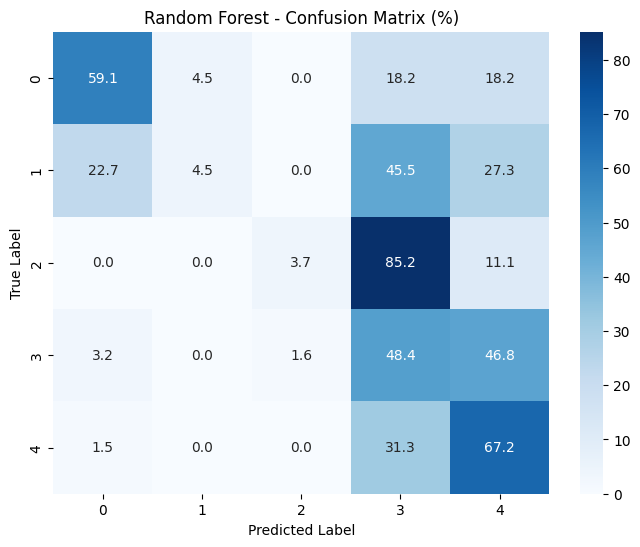

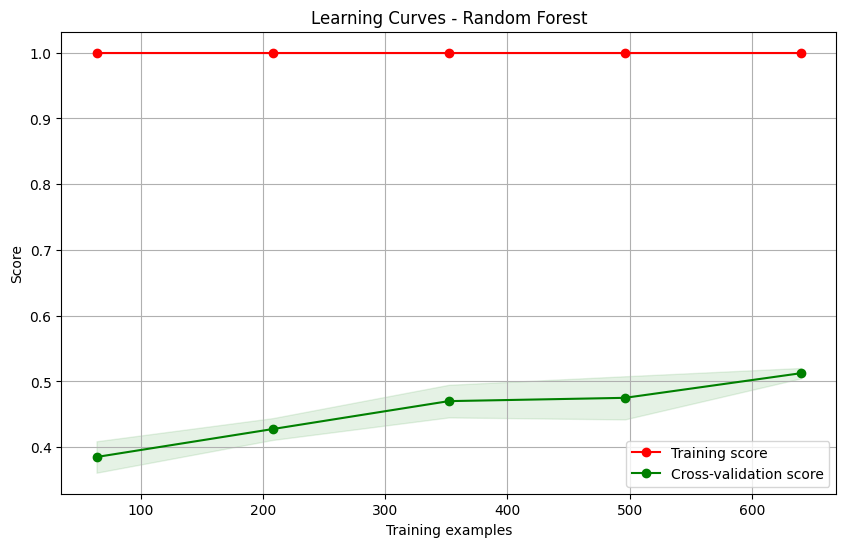


Grid Search Results for Random Forest:


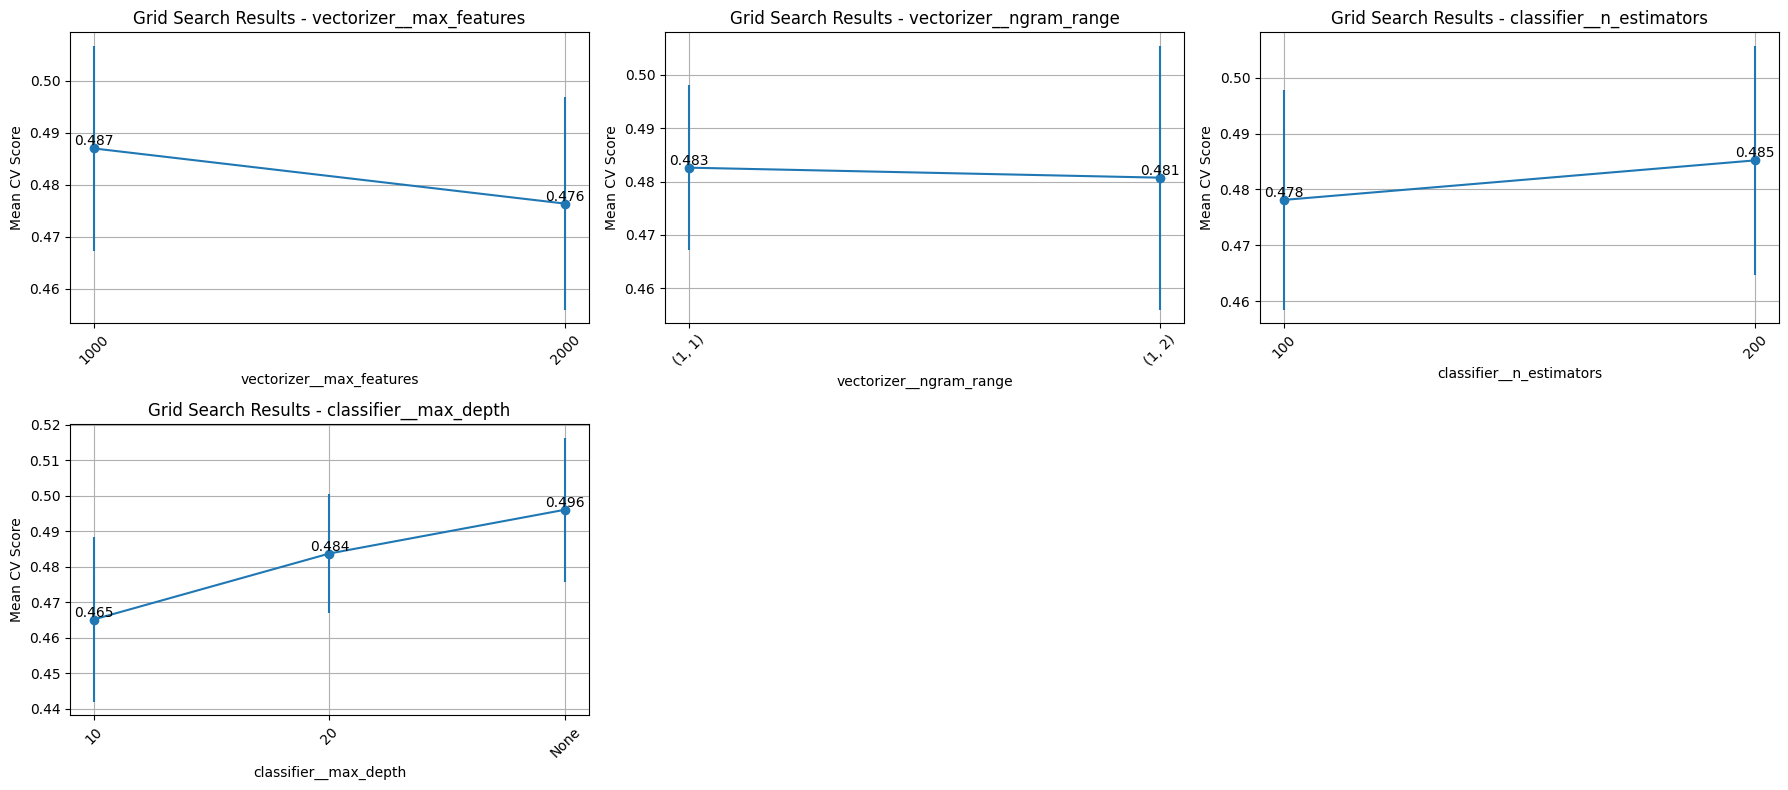


Top Features for Random Forest:


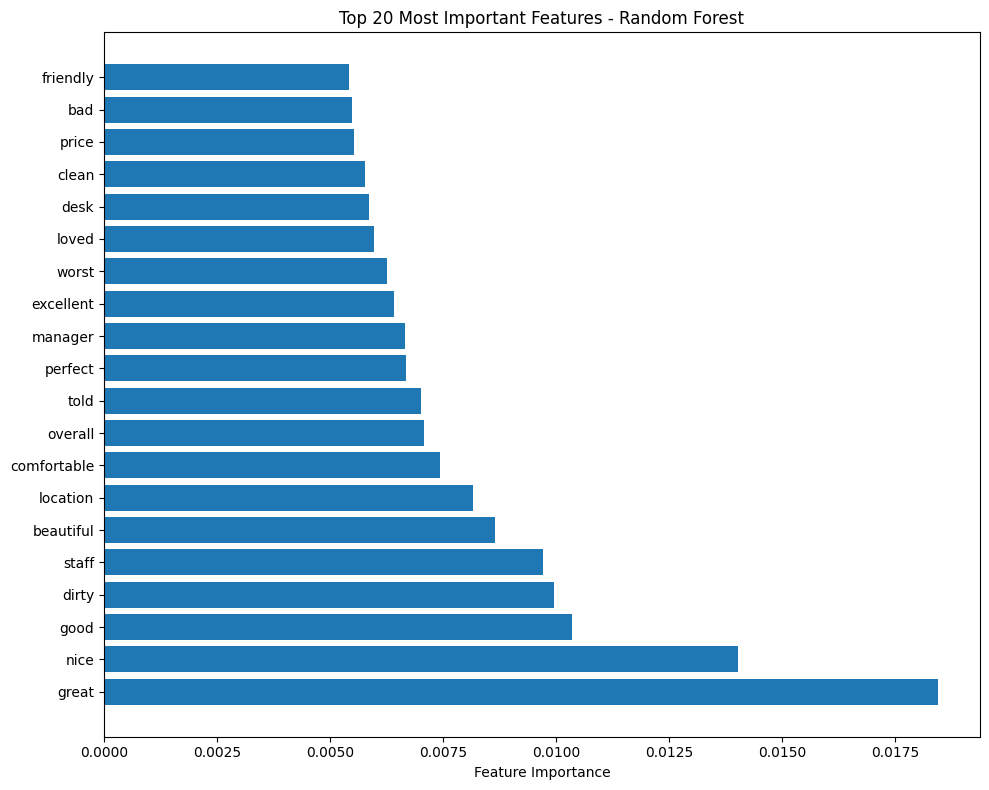


Class-specific Features for Random Forest:

Training XGBoost with Grid Search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

XGBoost Results:
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 300, 'vectorizer__max_features': 2000, 'vectorizer__ngram_range': (1, 2)}
Best CV score: 0.530
Training accuracy: 1.000
Testing accuracy: 0.500

Classification Report:
              precision    recall  f1-score   support

           1       0.53      0.45      0.49        22
           2       0.55      0.27      0.36        22
           3       0.33      0.15      0.21        27
           4       0.45      0.53      0.49        62
           5       0.56      0.70      0.62        67

    accuracy                           0.50       200
   macro avg       0.48      0.42      0.43       200
weighted avg       0.49      0.50      0.48       200



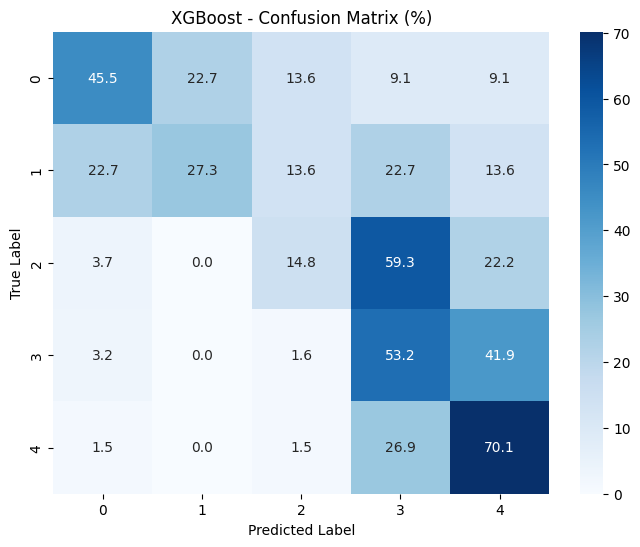

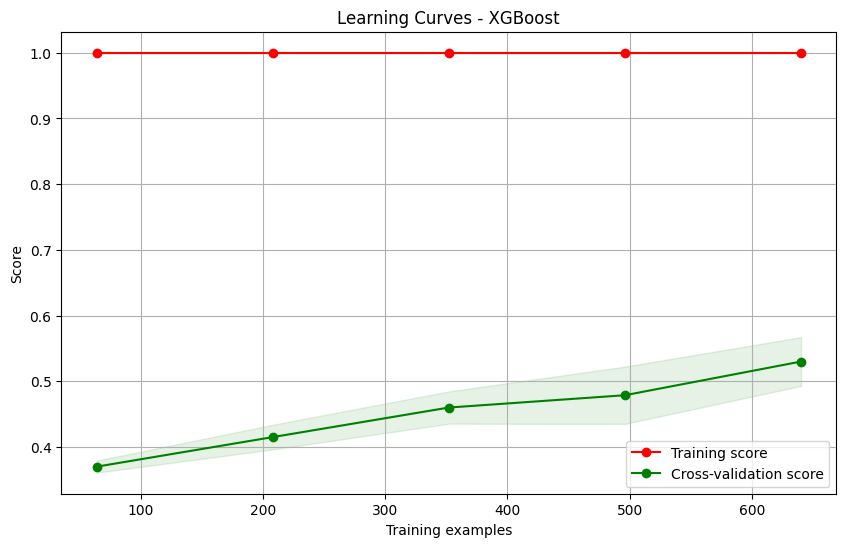


Grid Search Results for XGBoost:


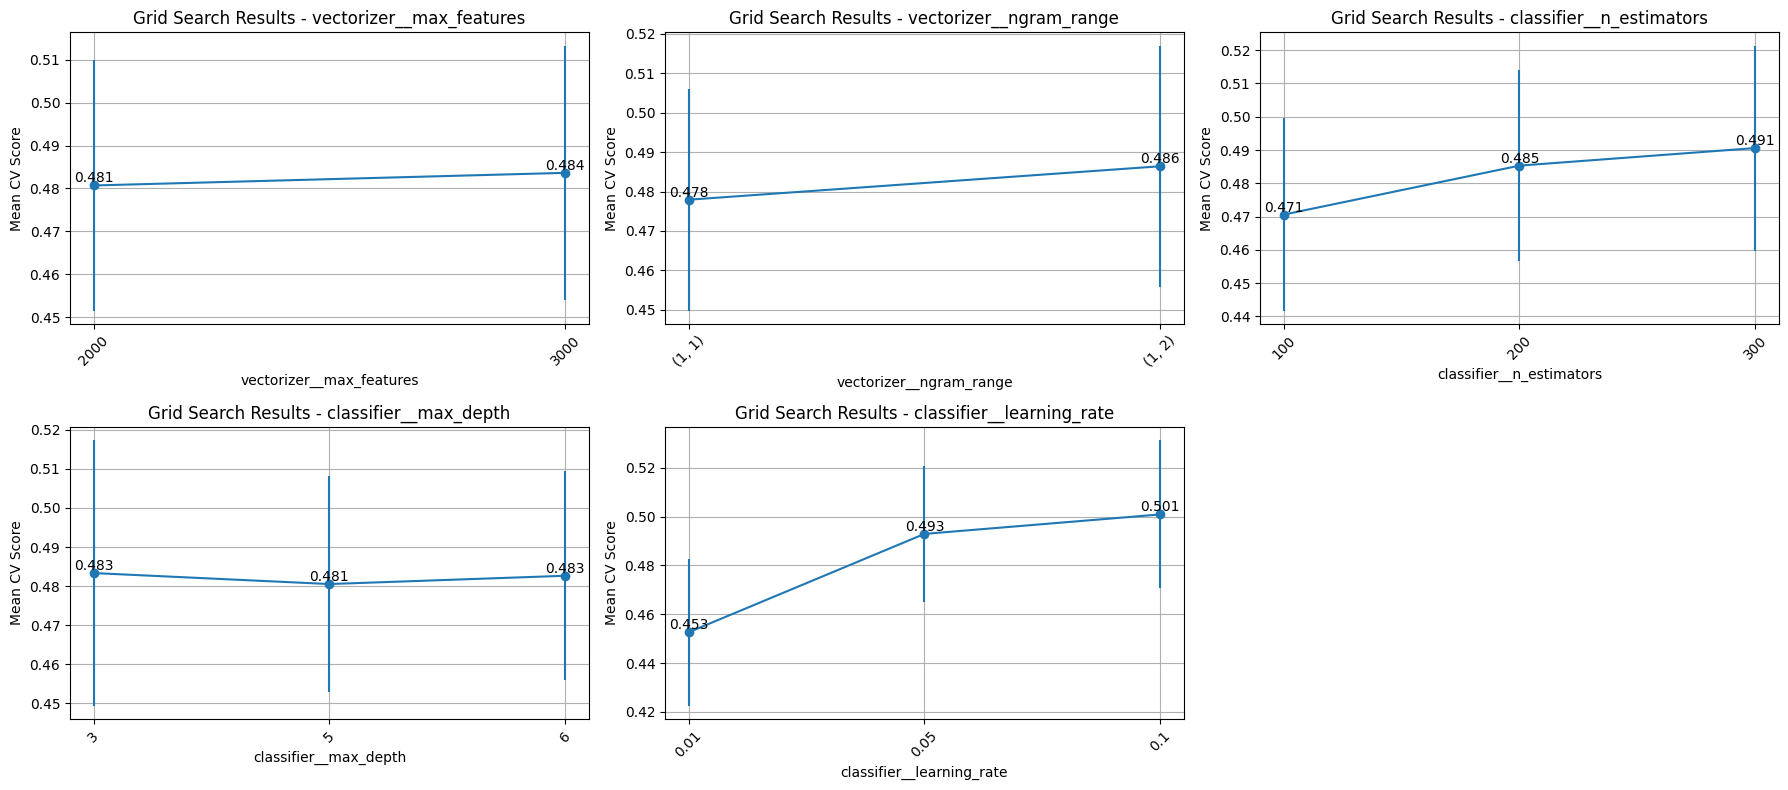


Top Features for XGBoost:


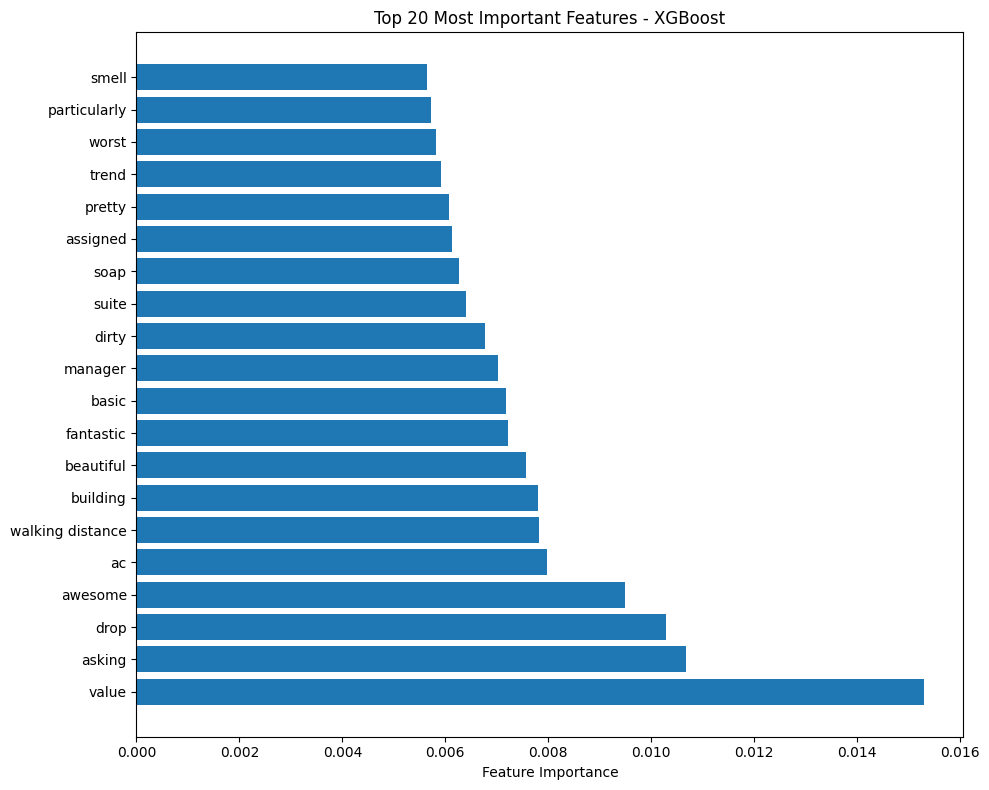


Class-specific Features for XGBoost:

Training Naive Bayes with Grid Search...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Naive Bayes Results:
Best parameters: {'classifier__alpha': 0.1, 'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 2)}
Best CV score: 0.515
Training accuracy: 0.851
Testing accuracy: 0.500

Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.45      0.57        22
           2       0.38      0.23      0.29        22
           3       0.18      0.07      0.11        27
           4       0.42      0.56      0.48        62
           5       0.61      0.72      0.66        67

    accuracy                           0.50       200
   macro avg       0.47      0.41      0.42       200
weighted avg       0.48      0.50      0.48       200



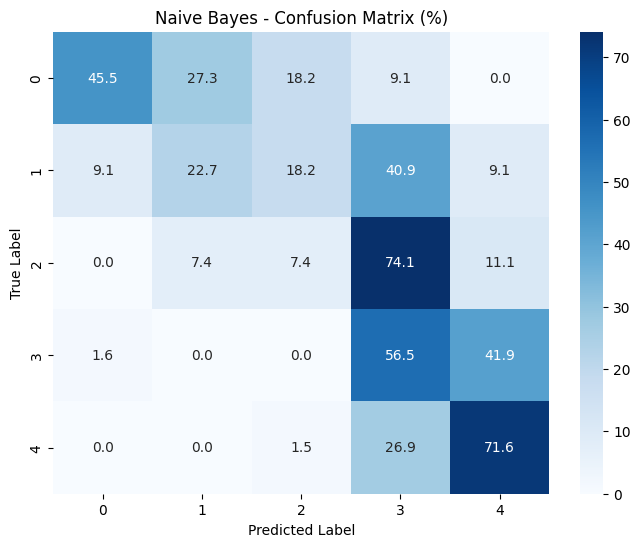

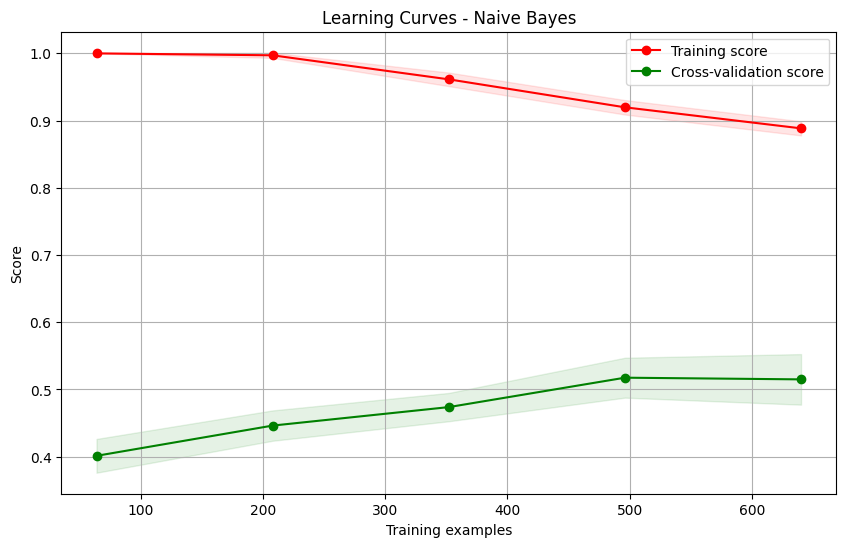


Grid Search Results for Naive Bayes:


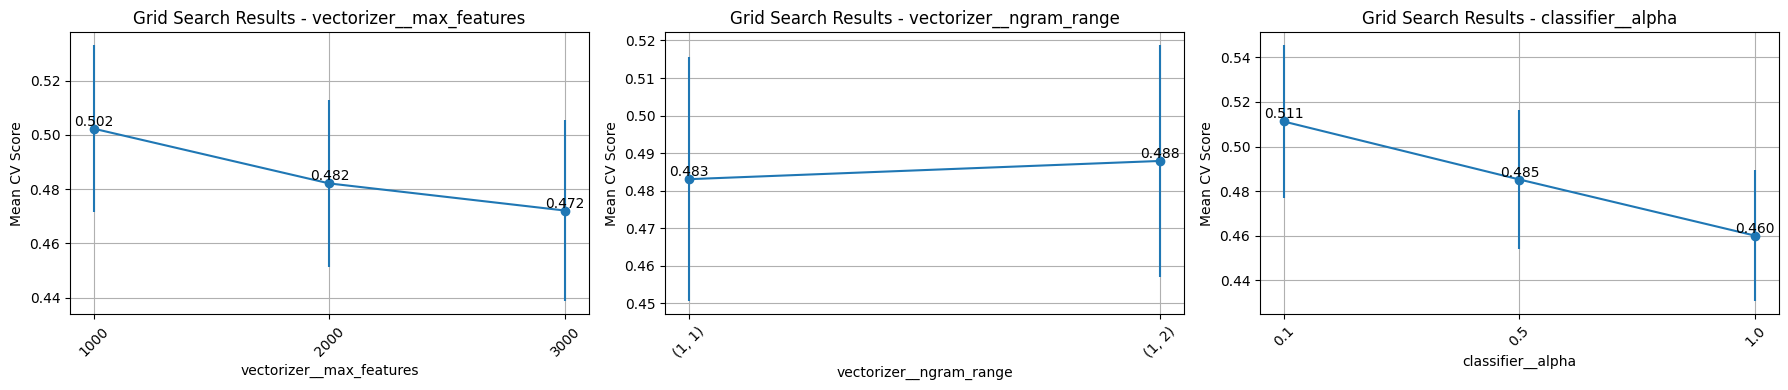


Top Features for Naive Bayes:


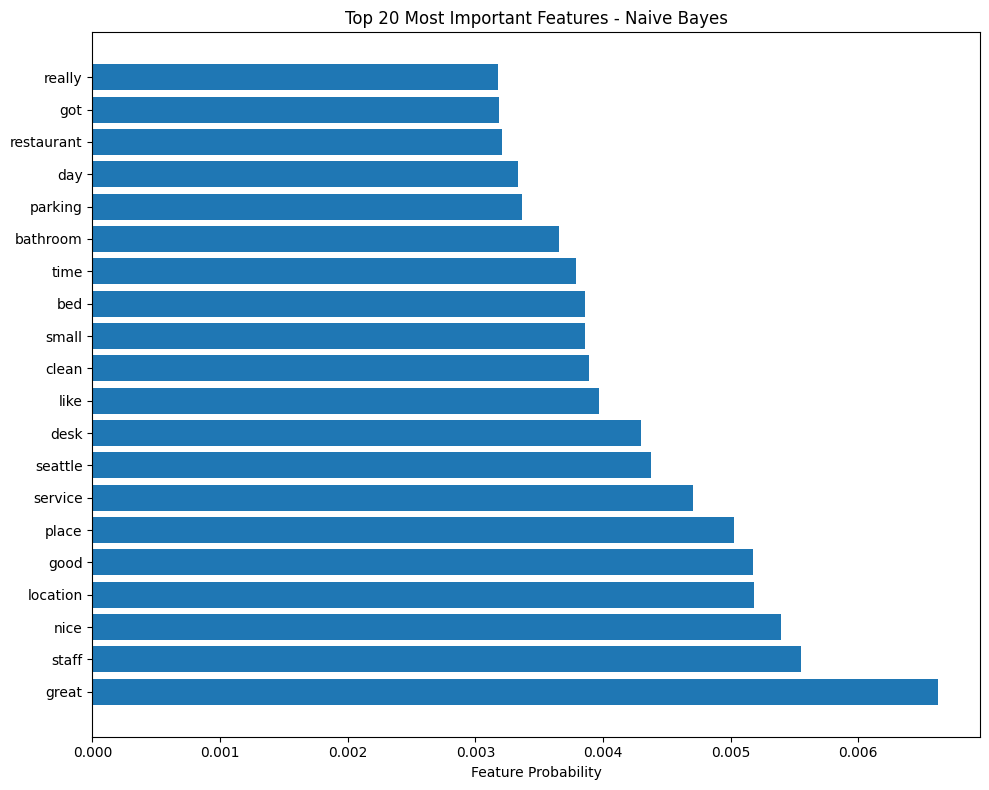


Class-specific Features for Naive Bayes:


In [59]:
# Compare models
results = compare_models_with_grid_search(X_train, X_test, y_train, y_test)

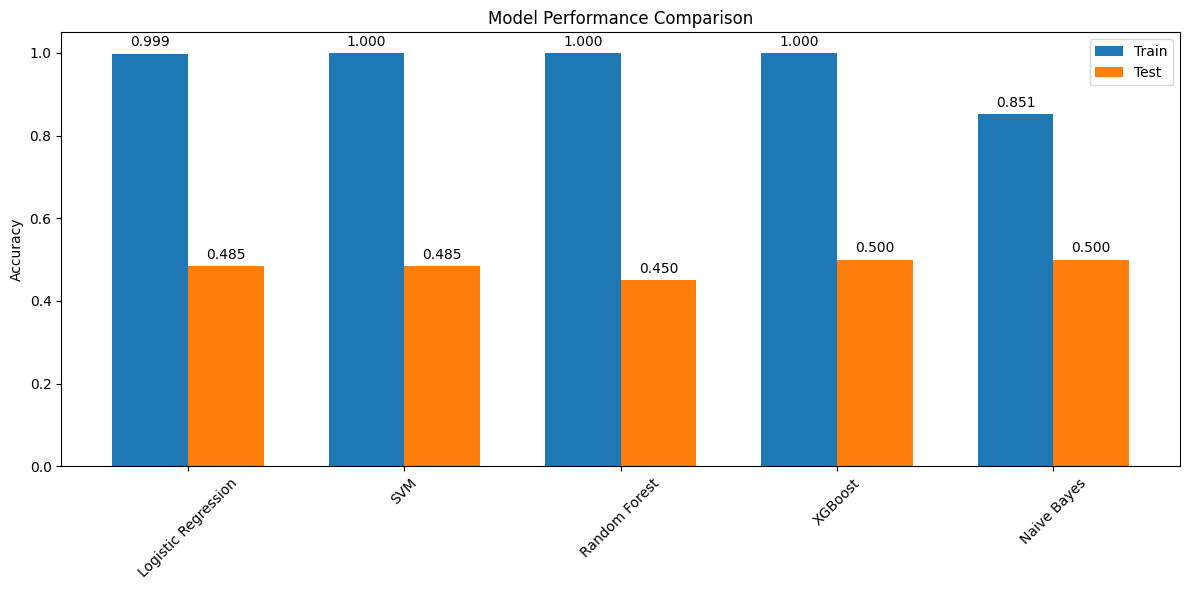

In [60]:
# Plot comparison
plot_model_comparison(results)